## Comparing Models
We want to compare **four approaches** to modeling our data from *control* and *mutant* mice.
The idea is to show that a **full regression model with group and slope terms** outperforms simple means or partial models.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

### **1. Data Setup**

We have:

* A **binary group variable**:

  $$
  \text{group} =
  \begin{cases}
  0 & \text{Control mice} \\
  1 & \text{Mutant mice}
  \end{cases}
  $$
* A **continuous predictor** $x$ (e.g., age, weight, dosage).
* A **response variable** $y$ (e.g., measured outcome).

In [2]:
groups = np.array(['Control'] * 4 + ['Mutant'] * 4)
weights = np.array([21.0, 19.5, 20.2, 20.7, 24.8, 25.1, 23.9, 24.4])

df = pd.DataFrame({'Group': groups, 'Weight': weights})
df

,Group,Weight
0,Control,21.0
1,Control,19.5
2,Control,20.2
3,Control,20.7
4,Mutant,24.8
5,Mutant,25.1
6,Mutant,23.9
7,Mutant,24.4


<Figure size 600x400 with 0 Axes>

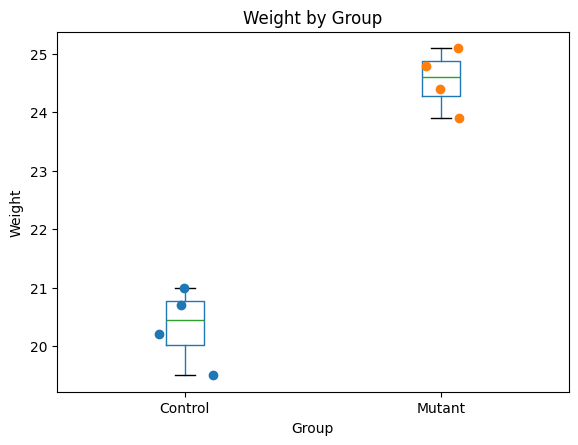

In [5]:
plt.figure(figsize=(6, 4))
ax = df.boxplot(column='Weight', by='Group', grid=False)
for i, g in enumerate(df['Group'].unique()):
    y = df.loc[df['Group']==g, 'Weight']
    x = np.random.normal(i+1, 0.05,size=len(y))
    plt.plot(x, y, 'o')
plt.suptitle('')
plt.title('Weight by Group')
plt.xlabel('Group')
plt.ylabel('Weight')
plt.show()

## **2. Models to Compare**

### **Model A: Mean Only**

This is the simplest possible model:

$$
y = \mu + \varepsilon
$$

where $\mu$ is just the overall mean of all data points.
No group information, no slope — **same prediction for everyone**.


### **Model B: Intercept + Slope (No Group Info)**

Here we fit a straight line to **all mice pooled together**:

$$
y = \beta_0 + \beta_1 x + \varepsilon
$$

Still ignores the group difference — assumes **both control and mutant follow the same line**.


### **Model C: Mean Control + t-test for Difference**

This is the classic **two-sample t-test** setup:

1. Compute the mean for **control** group: $\mu_c$
2. Compute the mean for **mutant** group: $\mu_m$
3. Difference:

$$
\Delta = \mu_m - \mu_c
$$

4. Test:

$$
t = \frac{\Delta}{SE(\Delta)}
$$

This tests whether the **two group means are significantly different** (no slope term).


### **Model D: Full Regression Model (Group + Slope)**

This is the **design matrix** approach:

$$
y = \beta_0 + \beta_g \cdot \text{group} + \beta_1 x + \varepsilon
$$

Where:

* $\beta_0$: intercept for **control group** (when $x = 0$)
* $\beta_g$: **offset** for mutant group (difference in intercept between mutant and control)
* $\beta_1$: slope shared by both groups
  (or you could extend to have **different slopes per group** if interaction is included)

**Interpretation:**

* $\beta_g$ tells you how much higher/lower mutants are compared to controls **after adjusting for x**.
* The model uses **all data at once**, making it more powerful than a separate mean or t-test.




## **3. Why Model D is Better**

* **Adjusts for confounding**: If $x$ affects $y$, the t-test on raw means could be misleading.
* **Uses all variance**: Slope explains extra variability → smaller residual error → higher statistical power.
* **Generalizes**: Can extend to multiple groups, multiple predictors, interactions, etc.
